## Implementation of GC-LSTM with PyTorch

In [1]:
# import Yahoo Finance module to obtain dataset

import yfinance as yf

In [3]:
# import basic numerical and graphical tools

import time
import itertools
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# import stats and machine learning frameworks

from statsmodels.tsa.stattools import grangercausalitytests

from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor

In [7]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


### Proposed data acquisition

In [9]:
tickers = ['F', 'ALV', 'FDX', 'DNZOY', 'ASEKY', 'JCI', 'GM', 'TM', 'CL=F', 'X',  # Company tickers
           'EURUSD=X', 'CHFUSD=X', 'GBPUSD=X', 'JPYUSD=X', 'CADUSD=X', 'INRUSD=X', 'RUBUSD=X', 'TRYUSD=X',  # Currencies
           '^IRX', 'JPM', 'BAC', 'C', 'WFC',  # Financial companies and IRX
           '^IXIC', '^GSPC', '^DJI'  # NASDAQ, S&P 500, Dow Jones
          ]
raw_data = yf.download(tickers, period='5y')
raw_data = raw_data.dropna()
raw_data

[*********************100%***********************]  26 of 26 completed


Price                       Adj Close                                   \
Ticker                            ALV      ASEKY        BAC          C   
Date                                                                     
2019-12-03 00:00:00+00:00   72.677521  12.566667  29.003269  60.594921   
2019-12-04 00:00:00+00:00   72.929192  12.566667  29.277052  61.338623   
2019-12-05 00:00:00+00:00   73.783035  12.566667  29.383612  61.735241   
2019-12-06 00:00:00+00:00   74.609970  12.566667  29.898642  62.644215   
2019-12-09 00:00:00+00:00   73.585312  12.566667  29.756561  62.247574   
...                               ...        ...        ...        ...   
2024-11-22 00:00:00+00:00   98.889999   9.793000  47.000000  69.839996   
2024-11-25 00:00:00+00:00  101.570000   9.750000  47.500000  70.750000   
2024-11-26 00:00:00+00:00   99.290001  11.400000  47.750000  69.750000   
2024-11-27 00:00:00+00:00   98.599998  11.400000  47.770000  70.160004   
2024-11-29 00:00:00+00:00   99.120003  11.400000  47.509998  70.870003   

Price                                                                      \
Ticker                     CADUSD=X  CHFUSD=X       CL=F  DNZOY  EURUSD=X   
Date                                                                        
2019-12-03 00:00:00+00:00  0.751710  1.008644  56.099998  11.17  1.107911   
2019-12-04 00:00:00+00:00  0.752338  1.013274  58.430000  11.35  1.108525   
2019-12-05 00:00:00+00:00  0.757995  1.011890  58.430000  11.40  1.108303   
2019-12-06 00:00:00+00:00  0.758956  1.013171  59.200001  11.52  1.110543   
2019-12-09 00:00:00+00:00  0.754728  1.009611  59.020000  11.45  1.105889   
...                             ...       ...        ...    ...       ...   
2024-11-22 00:00:00+00:00  0.715308  1.127523  71.239998  14.75  1.046934   
2024-11-25 00:00:00+00:00  0.717731  1.123002  68.940002  14.73  1.047987   
2024-11-26 00:00:00+00:00  0.709300  1.125113  68.769997  14.50  1.044430   
2024-11-27 00:00:00+00:00  0.711587  1.128324  68.720001  14.09  1.049120   
2024-11-29 00:00:00+00:00  0.713919  1.133350  68.000000  14.34  1.056301   

Price                                 ...   Volume                     \
Ticker                             F  ... JPYUSD=X RUBUSD=X        TM   
Date                                  ...                               
2019-12-03 00:00:00+00:00   7.123958  ...        0        0  109300.0   
2019-12-04 00:00:00+00:00   7.172039  ...        0        0  175400.0   
2019-12-05 00:00:00+00:00   7.156012  ...        0        0   91500.0   
2019-12-06 00:00:00+00:00   7.228132  ...        0        0   93900.0   
2019-12-09 00:00:00+00:00   7.220120  ...        0        0   99300.0   
...                              ...  ...      ...      ...       ...   
2024-11-22 00:00:00+00:00  11.180000  ...        0        0  368900.0   
2024-11-25 00:00:00+00:00  11.400000  ...        0        0  347900.0   
2024-11-26 00:00:00+00:00  11.100000  ...        0        0  410700.0   
2024-11-27 00:00:00+00:00  11.100000  ...        0        0  478500.0   
2024-11-29 00:00:00+00:00  11.130000  ...        0        0  247700.0   

Price                                                                    \
Ticker                    TRYUSD=X         WFC           X         ^DJI   
Date                                                                      
2019-12-03 00:00:00+00:00        0  25560700.0  14249300.0  275350000.0   
2019-12-04 00:00:00+00:00        0  18867400.0  13412300.0  218200000.0   
2019-12-05 00:00:00+00:00        0  13499700.0   9670300.0  208600000.0   
2019-12-06 00:00:00+00:00        0  18325700.0  15431200.0  223310000.0   
2019-12-09 00:00:00+00:00        0  15070800.0  11718100.0  217000000.0   
...                            ...         ...         ...          ...   
2024-11-22 00:00:00+00:00        0  14997400.0   4956300.0  533010000.0   
2024-11-25 00:00:00+00:00        0  28636600.0   5305000.0  826660000.0   
2024-11-26 00:00:00+00:00        0  

### Find highly correlated tickers

In [12]:
close_data = pd.DataFrame(data=raw_data['Close']).reset_index()
close_data['Date'] = pd.to_datetime(close_data['Date']).dt.date
close_data = close_data.set_index('Date')
close_data.head()

Ticker,ALV,ASEKY,BAC,C,CADUSD=X,CHFUSD=X,CL=F,DNZOY,EURUSD=X,F,...,JPYUSD=X,RUBUSD=X,TM,TRYUSD=X,WFC,X,^DJI,^GSPC,^IRX,^IXIC
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-03,80.860001,12.566667,32.840000,73.330002,0.751710,1.008644,56.099998,11.17,1.107911,8.89,...,0.009172,0.015583,140.729996,0.174209,52.580002,13.14,27502.810547,3093.199951,1.538,8520.639648
2019-12-04,81.139999,12.566667,33.150002,74.230003,0.752338,1.013274,58.430000,11.35,1.108525,8.95,...,0.009204,0.015603,143.380005,0.174140,53.240002,13.34,27649.779297,3112.760010,1.498,8566.669922
2019-12-05,82.089996,12.566667,33.090000,74.709999,0.757995,1.011890,58.430000,11.40,1.108303,8.93,...,0.009188,0.015659,142.830002,0.174044,53.230000,13.33,27677.789062,3117.429932,1.493,8570.700195
2019-12-06,83.010002,12.566667,33.669998,75.809998,0.758956,1.013171,59.200001,11.52,1.110543,9.02,...,0.009196,0.015705,142.770004,0.174054,54.369999,13.94,28015.060547,3145.909912,1.480,8656.530273
2019-12-09,81.870003,12.566667,33.509998,75.330002,0.754728,1.009611,59.020000,11.45,1.105889,9.01,...,0.009206,0.015716,141.889999,0.173049,53.919998,14.09,27909.599609,3135.959961,1.498,8621.830078


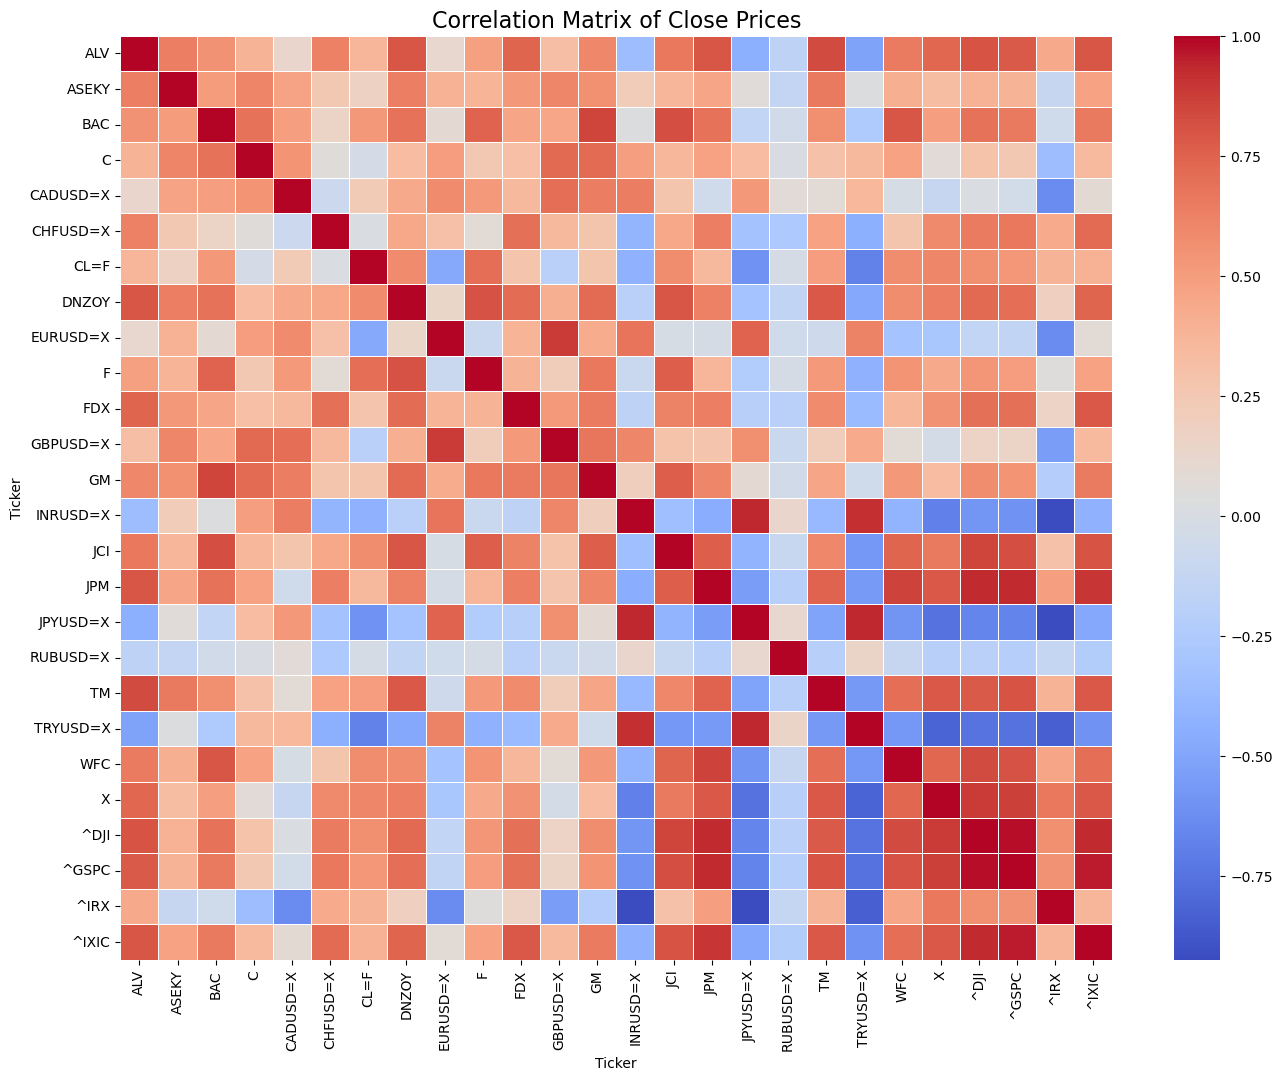

In [14]:
corr_mat = close_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_mat, cmap='coolwarm', linewidths=0.5, fmt='.1f')
plt.title('Correlation Matrix of Close Prices', fontsize=16)
plt.show()

In [18]:
ford_corr = corr_mat['F']
highly_corr_tickers = ford_corr[abs(ford_corr) >= 0.4]
highly_corr_tickers

Ticker
ALV         0.483006
BAC         0.751071
CADUSD=X    0.515432
CL=F        0.705618
DNZOY       0.805556
F           1.000000
GM          0.665100
JCI         0.766611
TM          0.513907
TRYUSD=X   -0.424538
WFC         0.544160
X           0.441057
^DJI        0.537138
^GSPC       0.501420
^IXIC       0.474885
Name: F, dtype: float64

### Check granger causality

In [21]:
## https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/
def grangers_causation_matrix(data, variables,test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=10, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(10)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            #opt_lag = 1 + np.argmin(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [23]:
highly_granger_causal_tickers = []
optimal_lags = []

for ticker in highly_corr_tickers.index:
    gc = close_data[['F', ticker]].copy()
    gc_test_result = grangercausalitytests(gc.dropna(), maxlag=10)
    p_values = [round(gc_test_result[i + 1][0]['ssr_ftest'][1], 4) for i in range(10)]
    min_p_value = np.min(p_values)
    if min_p_value < 0.05:
        highly_granger_causal_tickers.append(ticker)
        optimal_lags.append(1 + np.argmin(p_values))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3047  , p=0.2536  , df_denom=1253, df_num=1
ssr based chi2 test:   chi2=1.3078  , p=0.2528  , df=1
likelihood ratio test: chi2=1.3071  , p=0.2529  , df=1
parameter F test:         F=1.3047  , p=0.2536  , df_denom=1253, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5795  , p=0.5603  , df_denom=1250, df_num=2
ssr based chi2 test:   chi2=1.1637  , p=0.5589  , df=2
likelihood ratio test: chi2=1.1631  , p=0.5590  , df=2
parameter F test:         F=0.5795  , p=0.5603  , df_denom=1250, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8199  , p=0.4829  , df_denom=1247, df_num=3
ssr based chi2 test:   chi2=2.4734  , p=0.4801  , df=3
likelihood ratio test: chi2=2.4709  , p=0.4806  , df=3
parameter F test:         F=0.8199  , p=0.4829  , df_denom=1247, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6473  , p=0.

In [25]:
if 'F' not in highly_granger_causal_tickers:
    highly_granger_causal_tickers.append('F')
highly_granger_causal_tickers = pd.Series(index=pd.Index(highly_granger_causal_tickers))

In [27]:
optimal_lags

[9, 1, 5, 10, 9, 2]

### Define and calculate indicators

In [30]:
# Gain, Loss, Avg_Gain, and Avg_Loss
def gain_loss(df):
    df['Change'] = df['Close'].diff()
    df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)
    df['Loss'] = df['Change'].apply(lambda x: -x if x < 0 else 0)
    df['Avg_Gain'] = df['Gain'].rolling(window=14).mean()
    df['Avg_Loss'] = df['Loss'].rolling(window=14).mean()
    return df

# Simple Moving Average (SMA)
def SMA(df, window=20):
    df['SMA'] = df['Close'].rolling(window=window).mean()
    return df

# Exponential Moving Average (EMA)
def EMA(df, window=20):
    df['EMA'] = df['Close'].ewm(span=window, adjust=False).mean()
    return df

# Relative Strength Index (RSI)
def RSI(df):
    df['change_in_price'] = df['Close'].diff()
    up_df, down_df = df[['change_in_price']].copy(), df[['change_in_price']].copy()
    up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
    down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
    down_df['change_in_price'] = down_df['change_in_price'].abs()
    ewma_up = up_df['change_in_price'].ewm(span=14).mean()
    ewma_down = down_df['change_in_price'].ewm(span=14).mean()
    relative_strength = ewma_up / ewma_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + relative_strength))
    return df

# Stochastic Oscillator
def SO(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['k_percent'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    return df

# Williams %R
def r_percent(df):
    low_14 = df['Low'].rolling(window=14).min()
    high_14 = df['High'].rolling(window=14).max()
    df['r_percent'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))
    return df

# Moving Average Convergence Divergence (MACD)
def MACD(df):
    ema_26 = df['Close'].ewm(span=26).mean()
    ema_12 = df['Close'].ewm(span=12).mean()
    macd = ema_12 - ema_26
    df['MACD'] = macd
    df['MACD_EMA'] = macd.ewm(span=9).mean()
    return df

# Price Rate of Change (PROC)
def ROC(df, n=12):
    df['ROC'] = df['Close'].pct_change(periods=n) * 100
    return df

# Price Volume Trend (PVT)
def PVT(df):
    df['PVT'] = (df['Close'].pct_change() * df['Volume']).cumsum()
    return df

# Bollinger Bands
def Bollinger_Bands(df, window=20):
    sma = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['Bollinger_Upper'] = sma + (rolling_std * 2)
    df['Bollinger_Lower'] = sma - (rolling_std * 2)
    return df

In [32]:
def calculate_indicators(df, ticker):
    df = gain_loss(df)
    df = SMA(df)
    df = EMA(df)
    df = RSI(df)
    df = SO(df)
    df = r_percent(df)
    df = MACD(df)
    df = ROC(df)
    df = PVT(df)
    df = Bollinger_Bands(df)
    
    df = df.rename(columns=lambda col: f"{ticker}_{col}")
    
    return df

In [34]:
def create_dataset(data, tickers, target):
    df_features = pd.DataFrame()
    
    # Add the indicators and volume for each selected feature
    for ticker in tickers.index:
        try:
            # Extract the individual ticker data (Close, High, Low, Volume)
            ticker_data = pd.DataFrame({
                'Close': data['Close'][ticker],
                'High': data['High'][ticker],
                'Low': data['Low'][ticker],
                'Volume': data['Volume'][ticker]
            })
        except KeyError:
            print(f"Ticker '{ticker}' not found in data. Skipping.")
            continue
        
        # Calculate indicators and add to the dataset
        indicator_data = calculate_indicators(ticker_data.copy(), ticker)
        
        # Merge the calculated indicators into the final feature dataset
        df_features = pd.concat([df_features, indicator_data], axis=1)
    
    # Add Ford's closing price as the predictor variable
    #df_features[f'{target}_Close'] = data['Close'][target]
    
    # # Apply the prediction_class function on Denso's Close price
    # df_features = prediction_class(df_features)
    
    return df_features

In [36]:
dataset_reg = create_dataset(raw_data, highly_granger_causal_tickers, target='F')
dataset_reg = dataset_reg.dropna()
dataset_reg

,CADUSD=X_Close,CADUSD=X_High,CADUSD=X_Low,CADUSD=X_Volume,CADUSD=X_Change,CADUSD=X_Gain,CADUSD=X_Loss,CADUSD=X_Avg_Gain,CADUSD=X_Avg_Loss,CADUSD=X_SMA,...,F_change_in_price,F_RSI,F_k_percent,F_r_percent,F_MACD,F_MACD_EMA,F_ROC,F_PVT,F_Bollinger_Upper,F_Bollinger_Lower
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31 00:00:00+00:00,0.765662,0.772016,0.765650,0,0.000750,0.000750,0.000000,0.001026,0.000297,0.759201,...,0.050000,48.388832,47.058846,-52.941154,0.035371,0.048791,-0.214587,2.074601e+06,9.668690,8.832310
2020-01-02 00:00:00+00:00,0.770832,0.771087,0.768817,0,0.005170,0.005170,0.000000,0.001370,0.000297,0.760157,...,0.120000,59.356289,67.391390,-32.608610,0.036999,0.046410,2.058511,2.634932e+06,9.665091,8.888909
2020-01-03 00:00:00+00:00,0.770238,0.771533,0.768988,0,-0.000594,0.000000,0.000594,0.001131,0.000339,0.761052,...,-0.210000,41.534317,14.285812,-85.714188,0.023732,0.041841,-1.916936,1.630838e+06,9.648241,8.931759
2020-01-06 00:00:00+00:00,0.770024,0.771426,0.769906,0,-0.000214,0.000000,0.000214,0.001049,0.000354,0.761653,...,-0.050000,38.369320,19.607759,-80.392241,0.009765,0.035388,-2.449419,1.395374e+06,9.624073,8.978926
2020-01-07 00:00:00+00:00,0.771373,0.771784,0.767501,0,0.001348,0.001348,0.000000,0.001145,0.000228,0.762274,...,0.090000,46.790532,37.254873,-62.745127,0.004989,0.029279,-3.039832,1.837358e+06,9.608589,9.017411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22 00:00:00+00:00,0.715308,0.716379,0.713435,0,-0.000614,0.000000,0.000614,0.001093,0.001317,0.717246,...,0.380000,58.535056,81.481498,-18.518502,0.054790,0.051555,-0.089359,6.221073e+07,11.576416,10.155584
2024-11-25 00:00:00+00:00,0.717731,0.718030,0.713949,0,0.002423,0.002423,0.000000,0.001199,0.001317,0.717150,...,0.219999,64.721577,86.813106,-13.186894,0.084617,0.058168,4.014595,6.345967e+07,11.582508,10.152492
2024-11-26 00:00:00+00:00,0.709300,0.711521,0.705398,0,-0.008430,0.000000,0.008430,0.000948,0.001920,0.716617,...,-0.299999,52.416595,53.846186,-46.153814,0.083091,0.063152,1.185051,6.221076e+07,11.590143,10.213857


In [38]:
dataset_reg['F_Close']

Date
2019-12-31 00:00:00+00:00     9.30
2020-01-02 00:00:00+00:00     9.42
2020-01-03 00:00:00+00:00     9.21
2020-01-06 00:00:00+00:00     9.16
2020-01-07 00:00:00+00:00     9.25
                             ...  
2024-11-22 00:00:00+00:00    11.18
2024-11-25 00:00:00+00:00    11.40
2024-11-26 00:00:00+00:00    11.10
2024-11-27 00:00:00+00:00    11.10
2024-11-29 00:00:00+00:00    11.13
Name: F_Close, Length: 1238, dtype: float64

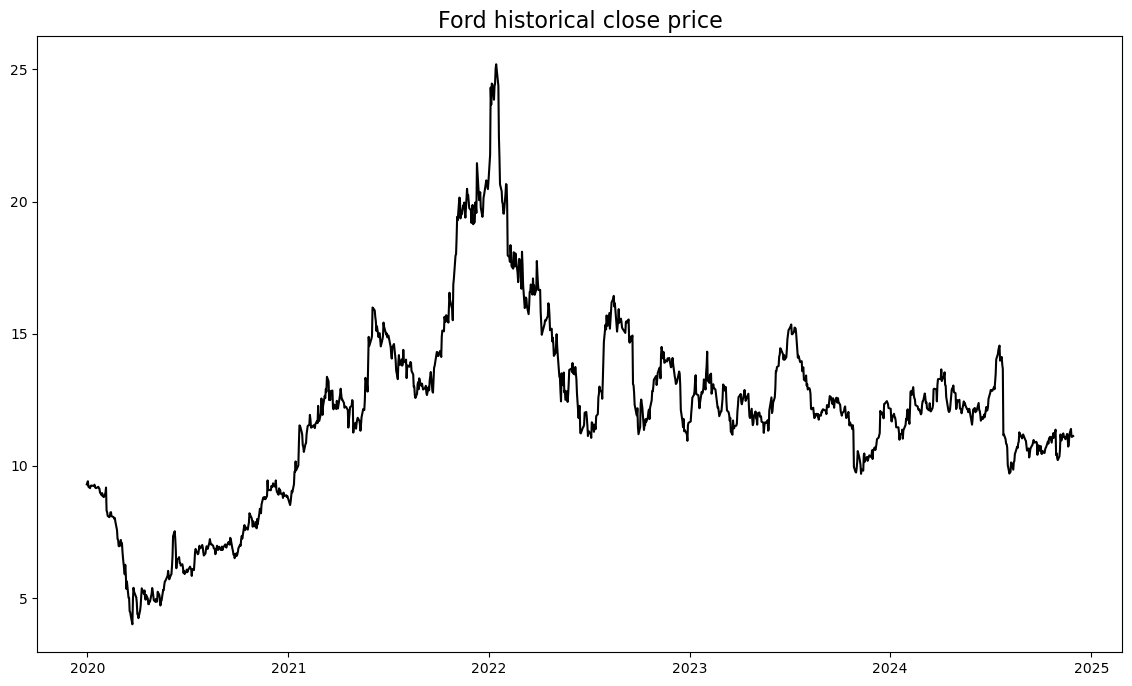

In [40]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(dataset_reg['F_Close'], color='k')
plt.title('Ford historical close price', fontsize=16)
plt.show()

### Transform the data to scale

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = {}
for column in dataset_reg.columns:
    scaled_data[column] = scaler.fit_transform(dataset_reg[column].values.reshape(-1, 1)).reshape(-1)

scaled_dataset_reg = pd.DataFrame(scaled_data, index=dataset_reg.index)
exploring_dataset = scaled_dataset_reg.tail(1)
scaled_dataset_reg = pd.concat([scaled_dataset_reg, exploring_dataset])
scaled_dataset_reg

,CADUSD=X_Close,CADUSD=X_High,CADUSD=X_Low,CADUSD=X_Volume,CADUSD=X_Change,CADUSD=X_Gain,CADUSD=X_Loss,CADUSD=X_Avg_Gain,CADUSD=X_Avg_Loss,CADUSD=X_SMA,...,F_change_in_price,F_RSI,F_k_percent,F_r_percent,F_MACD,F_MACD_EMA,F_ROC,F_PVT,F_Bollinger_Upper,F_Bollinger_Lower
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31 00:00:00+00:00,0.538591,0.564139,0.569523,0.0,0.532875,0.060555,0.000000,0.295900,0.057789,0.441770,...,0.506931,0.472560,0.470588,0.470588,0.450994,0.462532,0.510030,0.274963,0.202807,0.335587
2020-01-02 00:00:00+00:00,0.575268,0.557478,0.591040,0.0,0.710409,0.417597,0.000000,0.400111,0.057789,0.449600,...,0.520792,0.603130,0.673914,0.673914,0.451658,0.461434,0.538806,0.276736,0.202639,0.339262
2020-01-03 00:00:00+00:00,0.571056,0.560678,0.592205,0.0,0.478917,0.000000,0.047433,0.327818,0.066516,0.456931,...,0.455446,0.390956,0.142858,0.142858,0.446251,0.459325,0.488480,0.273559,0.201851,0.342044
2020-01-06 00:00:00+00:00,0.569541,0.559910,0.598440,0.0,0.494190,0.000000,0.017055,0.302868,0.069654,0.461857,...,0.487129,0.353276,0.196078,0.196078,0.440558,0.456348,0.481740,0.272814,0.200720,0.345106
2020-01-07 00:00:00+00:00,0.579107,0.562472,0.582099,0.0,0.556917,0.108906,0.000000,0.332008,0.043632,0.466942,...,0.514852,0.453532,0.372549,0.372549,0.438612,0.453530,0.474266,0.274212,0.199996,0.347605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25 00:00:00+00:00,0.198564,0.176885,0.218254,0.0,0.600088,0.195728,0.000000,0.348285,0.267822,0.097352,...,0.540594,0.667005,0.868131,0.868131,0.471065,0.466858,0.563568,0.469172,0.292334,0.421302
2024-11-26 00:00:00+00:00,0.138758,0.130196,0.160153,0.0,0.164176,0.000000,0.673453,0.272192,0.391729,0.092990,...,0.437624,0.520512,0.538462,0.538462,0.470443,0.469158,0.527748,0.465221,0.292691,0.425286
2024-11-27 00:00:00+00:00,0.154978,0.146371,0.194166,0.0,0.594594,0.184679,0.000000,0.321607,0.303975,0.090051,...,0.497030,0.520512,0.538462,0.538462,0.469570,0.470800,0.498093,0.465221,0.292945,0.429024


In [45]:
scaled_dataset_reg.shape

(1239, 147)

In [47]:
def gen_inputs(dataset, target='F_Close', window_size=60, test_size=1):
    rows, columns = dataset.shape
    n_data = rows - window_size
    
    x_inputs = np.zeros((n_data, window_size - 1, columns))
    y_inputs = np.zeros((n_data, 1))
    
    # create all possible sequences of length look_back
    for i in range(n_data):
        for j in range(window_size - 1):
            for k in range(columns):
                x_inputs[i][j][k] = dataset.iloc[i + j, k]
    
    for i in range(n_data):
        y_inputs[i, 0] = dataset[target].iloc[i + window_size - 1]
    
    #n_test = int(np.round(test_size * n_data))
    n_test = test_size
    n_train = n_data - n_test
    
    x_train = x_inputs[:n_train, :, :]
    x_test = x_inputs[n_train:, :, :]
    y_train = y_inputs[:n_train, 0]
    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_inputs[n_train:, 0]
    y_test = y_test.reshape(y_test.shape[0], 1)
    
    return x_train, y_train, x_test, y_test

In [49]:
x_train, y_train, x_test, y_test = gen_inputs(scaled_dataset_reg)

In [51]:
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (1178, 59, 147)
y_train.shape =  (1178, 1)
x_test.shape =  (1, 59, 147)
y_test.shape =  (1, 1)


In [53]:
x_train_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.Tensor)

In [55]:
x_train_tensor.size(), y_train_tensor.size()

(torch.Size([1178, 59, 147]), torch.Size([1178, 1]))

In [57]:
n_features = x_train_tensor.size(-1)
n_features

147

### Build LSTM Models

In [60]:
class multi_LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(multi_LSTM, self).__init__()
        # module hyperparameters
        
        # input_dim: number of features of the input data x
        # hidden_dim: number of features in the hidden state h
        # num_layers: number of stacked LSTM layers
        # output_dim: number of features of the output data of the module
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # batch_first=True: input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # by torch.Tensor.detach, the truncated backpropagation through time (BPTT) is applied
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # index hidden state of last time step: choose only the last time step of the hidden states
        # ex) out.size() --> 100, 32, 100 so that out[:, -1, :] --> 100, 100
        out = self.fc(out[:, -1, :]) 

        return out

### Train the GC-LSTM model

In [62]:
num_epochs = 1000
loss_hist = np.zeros((num_epochs))

model = multi_LSTM(input_dim=n_features, hidden_dim=256, output_dim=1, num_layers=2)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

multi_LSTM(
  (lstm): LSTM(147, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
10
torch.Size([1024, 147])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024, 256])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([1024])
torch.Size([1, 256])
torch.Size([1])


In [66]:
for t in range(num_epochs):
    # train the model by the forward propagation
    y_train_pred = model(x_train_tensor)

    # calculate loss
    loss = loss_fn(y_train_pred, y_train_tensor)
    loss_hist[t] = loss.item()
    
    if t % 10 == 0 and t !=0:
        print(f"Epoch: {t} \t MSE: {loss.item()}")
    
    # reset the previous gradient values in the optimizer not to make accumulation
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

Epoch: 10 	 MSE: 0.023987920954823494
Epoch: 20 	 MSE: 0.11382769048213959
Epoch: 30 	 MSE: 0.03067011386156082
Epoch: 40 	 MSE: 0.01580970175564289
Epoch: 50 	 MSE: 0.007438169792294502
Epoch: 60 	 MSE: 0.004579402972012758
Epoch: 70 	 MSE: 0.002672541420906782
Epoch: 80 	 MSE: 0.0018783967243507504
Epoch: 90 	 MSE: 0.0013714393135160208
Epoch: 100 	 MSE: 0.0010204478166997433
Epoch: 110 	 MSE: 0.0008212476968765259
Epoch: 120 	 MSE: 0.0006957979639992118
Epoch: 130 	 MSE: 0.0006031144293956459
Epoch: 140 	 MSE: 0.0005367124103941023
Epoch: 150 	 MSE: 0.0004902895889244974
Epoch: 160 	 MSE: 0.00045619640150107443
Epoch: 170 	 MSE: 0.0004286348994355649
Epoch: 180 	 MSE: 0.00040440214797854424
Epoch: 190 	 MSE: 0.00038266737828962505
Epoch: 200 	 MSE: 0.0003632068110164255
Epoch: 210 	 MSE: 0.0003460243169683963
Epoch: 220 	 MSE: 0.0012499557342380285
Epoch: 230 	 MSE: 0.00045695455628447235
Epoch: 240 	 MSE: 0.00039870705222710967
Epoch: 250 	 MSE: 0.00034820367000065744
Epoch: 260 	 

### Loss function analysis

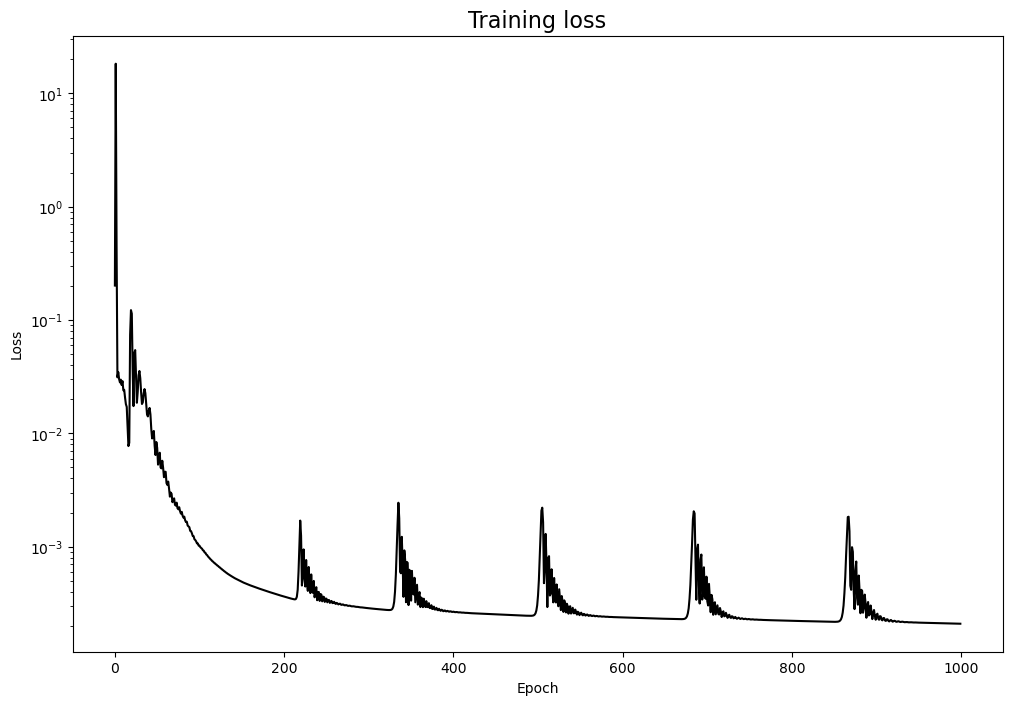

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(loss_hist, color='k')

plt.title('Training loss', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

### Predict next close price of the target ticker

In [79]:
# make a prediction by running the algorithm
y_test_pred = model(x_test_tensor)
    
# apply the inverse scaler
y_train = scaler.inverse_transform(y_train_tensor.detach().numpy())
y_test = scaler.inverse_transform(y_test_tensor.detach().numpy())
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())